In [0]:
import torch
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.preprocessing import OneHotEncoder
import time
from IPython.display import HTML

import warnings
warnings.filterwarnings('ignore')

In [0]:
torch.manual_seed(0)
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",["red","yellow","green"])
torch.device('cpu')

device(type='cpu')

## 1. Generate the dataset

In [0]:
data,labels = make_blobs(n_samples=1000,centers=4,n_features=2,random_state=0)
print(data.shape,labels.shape)

(1000, 2) (1000,)


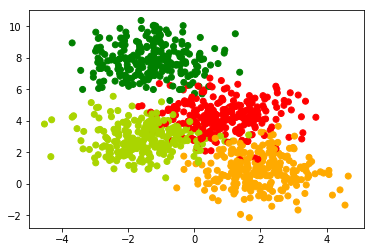

In [0]:
plt.scatter(data[:,0],data[:,1],c=labels,cmap=my_cmap)
plt.show()

In [0]:
X_train,X_test,Y_train,Y_test = train_test_split(data,labels,stratify=labels,random_state=0)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(750, 2) (250, 2) (750,) (250,)


## 2. Using PyTorch Tensors and autograd

In [0]:
# converting the numpy array into tensors
X_train, X_test, Y_train, Y_test = map(torch.tensor, (X_train,X_test,Y_train,Y_test))

X_train = X_train.float() 
Y_train = Y_train.long()
X_test = X_test.float() 
Y_test = Y_test.long()
# This is important to convert otherwise
# error: Expected object of scalar type Double but got scalar type Float for argument #2 'mat2'

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

torch.Size([750, 2]) torch.Size([250, 2]) torch.Size([750]) torch.Size([250])


In [0]:
a = torch.ones([2,4])
print(a)
print(a.exp())
print(a.exp().sum(1))
print(a.exp()/a.exp().sum(1).view(2,1))

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.]])
tensor([[2.7183, 2.7183, 2.7183, 2.7183],
        [2.7183, 2.7183, 2.7183, 2.7183]])
tensor([10.8731, 10.8731])
tensor([[0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500]])


In [0]:
# feedforward
def model(X):
  a1 = torch.matmul(X,W1) + B1 # (N,2) * (2,2) + (1,2) = (N,2)
  h1 = a1.sigmoid() # (N,2)
  a2 = torch.matmul(h1,W2) + B2 # (N,2) * (2,4) + (1,4) = (N,4)
  h2 = a2.exp()/(a2.exp().sum(1).unsqueeze(-1)) # (N,4)
 
  return h2

In [0]:
y_hat = torch.tensor([[0.8,0.1,0.05,0.05],[0.3,0.7,0.04,0.01]])
y_true = torch.tensor([[1,0]])
print(-y_hat[range(y_true.shape[0]),y_true])

def log_loss_function(Y_true,Y_pred):
  return (-Y_pred[range(Y_true.shape[0]),Y_true].log()).mean()

def return_accuracy(Y_true,Y_pred):
  return accuracy_score(Y_true, torch.argmax(Y_pred,dim=1))

tensor([[-0.1000, -0.8000]])


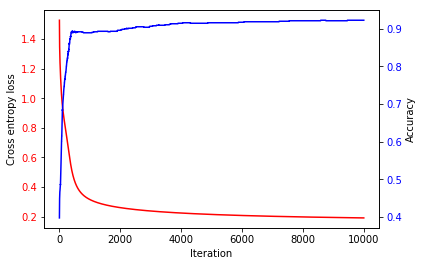

Accuracy before training:  0.3973333333333333
Accuracy after training:  0.9226666666666666
CPU times: user 9.13 s, sys: 762 ms, total: 9.89 s
Wall time: 9.76 s


In [0]:
%%time

W1 = torch.randn(2,2)/math.sqrt(2)
W1.requires_grad_()
B1 = torch.randn(1,2)/math.sqrt(2)
B1.requires_grad_()

W2 = torch.randn(2,4)/math.sqrt(2)
W2.requires_grad_()
B2 = torch.randn(1,4)/math.sqrt(2)
B2.requires_grad_()

learning_rate = 0.2
epochs = 10000

loss_arr = []
acc_arr = []

for epoch in range(epochs):
  
  Y_pred = model(X_train)
  
  loss = log_loss_function(Y_train,Y_pred)
  loss_arr.append(loss)
  acc_arr.append(return_accuracy(Y_train,Y_pred))
                  
  # do a backward pass using autograd function of pytorch library
  loss.backward()
  
  with torch.no_grad():
    # this is enclosed within the no_grad -> to ensure that 
    # there is no further computation of the grad
    
    W1.sub_(learning_rate*W1.grad)
    B1.sub_(learning_rate*B1.grad)
    W2.sub_(learning_rate*W2.grad)
    B2.sub_(learning_rate*B2.grad)
    
    # reset grad to zero
    W1.grad.zero_()
    B1.grad.zero_()
    W2.grad.zero_()
    B2.grad.zero_()
    

    
fig,ax1 = plt.subplots()
  
ax1.plot(loss_arr,'r-')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Cross entropy loss')
ax1.tick_params(axis='y',labelcolor='red')

ax2 = ax1.twinx()
ax2.plot(acc_arr,'b-')
ax2.set_ylabel('Accuracy')
ax2.tick_params(axis='y',labelcolor='blue')
plt.show()    
print('Accuracy before training: ',acc_arr[0])
print('Accuracy after training: ',acc_arr[-1])

Whenever we have an underscore in the end of a function in pytorch, that means that the function is in-place.

So x.sub_(w) is the same as x -= w for x and w tensors

## 3. Using NN.Functional 

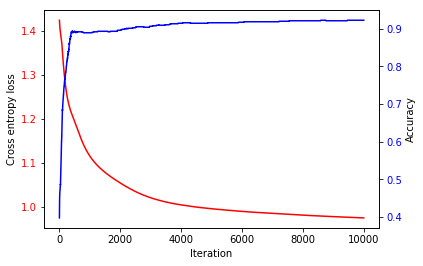

Accuracy before training:  0.3973333333333333
Accuracy after training:  0.9226666666666666


In [0]:
import torch.nn.functional as F

W1 = torch.randn(2,2)/math.sqrt(2)
W1.requires_grad_()
B1 = torch.randn(1,2)/math.sqrt(2)
B1.requires_grad_()

W2 = torch.randn(2,4)/math.sqrt(2)
W2.requires_grad_()
B2 = torch.randn(1,4)/math.sqrt(2)
B2.requires_grad_()

learning_rate = 0.2
epochs = 10000

loss_arr = []
accuracy = []

X_train = X_train.float()  # this is important otherwise 
Y_train = Y_train.long()
# error: Expected object of scalar type Double but got scalar type Float for argument #2 'mat2'


for epoch in range(epochs):
  
  Y_pred = model(X_train)
  
  loss = F.cross_entropy(Y_pred,Y_train) # note that in this syntax we have to place Y_pred first with M,N dimension
  
  loss_arr.append(loss)
  accuracy.append(return_accuracy(Y_train,Y_pred))
                  
  # do a backward pass using autograd function of pytorch library
  loss.backward()
  
  with torch.no_grad():
    # this is enclosed within the no_grad -> to ensure that 
    # there is no further computation of the grad
    
    W1.sub_(learning_rate*W1.grad)
    B1.sub_(learning_rate*B1.grad)
    W2.sub_(learning_rate*W2.grad)
    B2.sub_(learning_rate*B2.grad)
    
    # reset grad to zero
    W1.grad.zero_()
    B1.grad.zero_()
    W2.grad.zero_()
    B2.grad.zero_()
    

    
fig,ax1 = plt.subplots()
  
ax1.plot(loss_arr,'r-')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Cross entropy loss')
ax1.tick_params(axis='y',labelcolor='red')

ax2 = ax1.twinx()
ax2.plot(acc_arr,'b-')
ax2.set_ylabel('Accuracy')
ax2.tick_params(axis='y',labelcolor='blue')
plt.show()    
print('Accuracy before training: ',acc_arr[0])
print('Accuracy after training: ',acc_arr[-1])

## 4. Using NN.Parameter

Automatically the parameters are wrapped in parameters iterator.

In [0]:
import torch.nn as nn

In [0]:
class FirstNetwork(nn.Module):
  
  def __init__(self):
    super().__init__()
    torch.manual_seed(0)
    self.W1 = nn.Parameter(torch.randn(2,2) / math.sqrt(2))
    self.B1 = nn.Parameter(torch.randn(1,2) / math.sqrt(2))
    self.W2 = nn.Parameter(torch.randn(2,4) / math.sqrt(2))
    self.B2 = nn.Parameter(torch.randn(1,4) / math.sqrt(2))
    
    
  def forward(self,X):
    a1 = torch.matmul(X,self.W1) + self.B1
    h1 = a1.sigmoid()
    a2 = torch.matmul(h1,self.W2) + self.B2
    h2 = a2.exp()/a2.exp().sum(-1).unsqueeze(-1)
    return h2

In [0]:
# note that here the fit function is an independent function

def fit(epochs=10000, learning_rate=0.2):
  
  # arrays for book keeping
  loss_arr = []
  acc_arr = []
  for epoch in range(epochs):
    Y_hat = fn(X_train)
    loss = F.cross_entropy(Y_hat,Y_train)
    loss_arr.append(loss)
    acc_arr.append(return_accuracy(Y_train,Y_hat))
    
    # backpropagation with PyTorch's Autograd
    loss.backward()
    
    with torch.no_grad():
      for param in fn.parameters():
        param -= learning_rate * param.grad
      fn.zero_grad()
      
  fig,ax1 = plt.subplots()
  
  ax1.plot(loss_arr,'r-')
  ax1.set_xlabel('Iteration')
  ax1.set_ylabel('Cross entropy loss')
  ax1.tick_params(axis='y',labelcolor='red')
  
  ax2 = ax1.twinx()
  ax2.plot(acc_arr,'b-')
  ax2.set_ylabel('Accuracy')
  ax2.tick_params(axis='y',labelcolor='blue')
  plt.show()    
  print('Accuracy before training: ',acc_arr[0])
  print('Accuracy after training: ',acc_arr[-1])

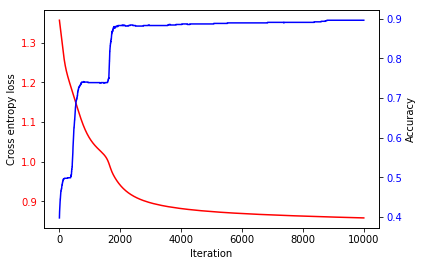

Accuracy before training:  0.3973333333333333
Accuracy after training:  0.896


In [0]:
fn = FirstNetwork()
fit()

## 5. Using NN.Linear and Optim

**NN.linear** is used to abstract out the forward pass of the neural network

**Optim** is used to abstract the loop for GD that we write it manually

**torch.optim** is a package implementing various optimization algorithms

In [0]:
class FirstNetwork_v1(nn.Module):
  
  def __init__(self):
    super().__init__()
    torch.manual_seed(0)
    self.lin1 = nn.Linear(2,2) # this will automatically have weights and biases
    self.lin2 = nn.Linear(2,4)
    
  def forward(self,X):
    a1 = self.lin1(X)
    h1 = a1.sigmoid()
    a2 = self.lin2(h1)
    h2 = a2.exp()/a2.exp().sum(-1).unsqueeze(-1)
    return h2

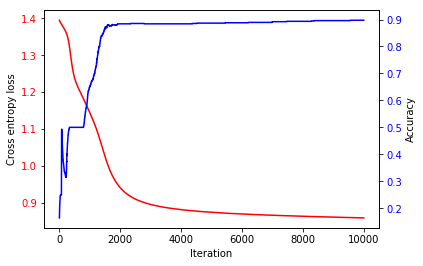

Accuracy before training:  0.164
Accuracy after training:  0.8973333333333333


In [0]:
fn = FirstNetwork_v1()
fit()

In [0]:
from torch import optim

def fit_v1(epochs=10000, learning_rate=0.2):
  
  # arrays for book keeping
  loss_arr = []
  acc_arr = []
  
  opt = optim.SGD(fn.parameters(), lr=learning_rate) # introducting the optimizer
  # using gradient descent 
  
  for epoch in range(epochs):
    
    Y_hat = fn(X_train)
    loss = F.cross_entropy(Y_hat,Y_train)
    loss_arr.append(loss)
    acc_arr.append(return_accuracy(Y_train,Y_hat))
    
    # backpropagation with PyTorch's Autograd
    loss.backward()
    # abstracting the loop for weights update using optim 
    opt.step()
    opt.zero_grad()
  
  fig,ax1 = plt.subplots()
  
  ax1.plot(loss_arr,'r-')
  ax1.plot(acc_arr,'b-')
  ax1.set_xlabel('Iteration')
  ax1.set_ylabel('Cross entropy loss')
  ax1.tick_params(axis='y',labelcolor='red')
  
  ax2 = ax1.twinx()
  ax2.set_ylabel('Accuracy')
  ax2.tick_params(axis='y',labelcolor='blue')
  plt.show()    
  print('Accuracy before training: ',acc_arr[0])
  print('Accuracy after training: ',acc_arr[-1])

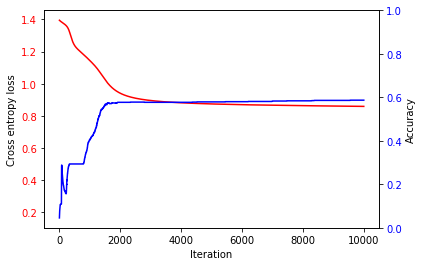

Accuracy before training:  0.164
Accuracy after training:  0.8973333333333333


In [0]:
fn = FirstNetwork_v1()
fit_v1()

## 6. Using NN Sequence

In [0]:
class FirstNetwork_v2(nn.Module):
  
  def __init__(self):
    super().__init__()
    torch.manual_seed(0)
    self.net = nn.Sequential(
        nn.Linear(2,2),
        nn.Sigmoid(),
        nn.Linear(2,4),
        nn.Softmax()
    )
    
  def forward(self,X):
    return self.net(X)

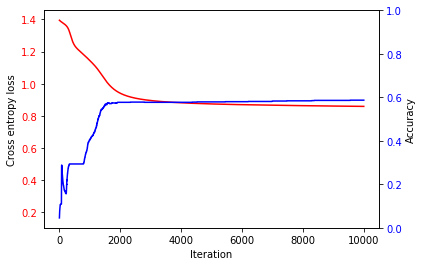

Accuracy before training:  0.164
Accuracy after training:  0.8973333333333333


In [0]:
fn = FirstNetwork_v2()
fit_v1()

In [0]:
# further abstracting the fit function
def fit_v2(X,Y,model,opt,loss_fn,epochs=10000): 
  for epoch in range(epochs):
    loss = loss_fn(model(X),Y)    
    loss.backward()
    opt.step()
    opt.zero_grad() 
  return loss.item()

In [0]:
fn = FirstNetwork_v2()
opt = optim.SGD(fn.parameters(), lr=0.2)
loss_fn = F.cross_entropy

train = fit_v2(X_train,Y_train,fn,opt,loss_fn)
test = fit_v2(X_test,Y_test,fn,opt,loss_fn)

print('Training error: ',train,' | Test error: ',test)

Training error:  0.8586323857307434  | Test error:  0.8360385894775391


## 7. Migrating to GPU

In [0]:
%%time

device = torch.device('cpu')

X_train = X_train.to(device)
Y_train = Y_train.to(device)
fn = FirstNetwork_v2()
fn.to(device)

fit_v2(X_train,Y_train,fn,opt,loss_fn)

CPU times: user 9.47 s, sys: 374 ms, total: 9.84 s
Wall time: 9.92 s


In [0]:
%%time

device = torch.device('cuda')

X_train = X_train.to(device)
Y_train = Y_train.to(device)
fn = FirstNetwork_v2()
fn.to(device)

fit_v2(X_train,Y_train,fn,opt,loss_fn)

CPU times: user 5.95 s, sys: 438 ms, total: 6.39 s
Wall time: 6.32 s


In [0]:
# trying for larger Network
class FirstNetwork_v3(nn.Module):
  
  def __init__(self):
    super().__init__()
    torch.manual_seed(0)
    self.net = nn.Sequential(
        nn.Linear(2,200),
        nn.Sigmoid(),
        nn.Linear(200,4),
        nn.Softmax()
    )
    
  def forward(self,X):
    return self.net(X)

In [0]:
%%time

device = torch.device('cpu')

X_train = X_train.to(device)
Y_train = Y_train.to(device)
fn = FirstNetwork_v3()
fn.to(device)

fit_v2(X_train,Y_train,fn,opt,loss_fn)

CPU times: user 24.2 s, sys: 892 ms, total: 25.1 s
Wall time: 25.4 s


In [0]:
%%time

device = torch.device('cuda')

X_train = X_train.to(device)
Y_train = Y_train.to(device)
fn = FirstNetwork_v3()
fn.to(device)

fit_v2(X_train,Y_train,fn,opt,loss_fn)

CPU times: user 6.08 s, sys: 412 ms, total: 6.49 s
Wall time: 6.45 s
